# Evaluation: deep learning for analysing immune cell interactions

## Colab file setup

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/l4_project')
sys.path.append('/content/gdrive/My Drive/l4_project/src')

In [3]:
%cd /content/gdrive/My Drive/l4_project/src

/content/gdrive/My Drive/l4_project/src


## Imports

In [4]:
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# (hopefully) disable tensorflow 2.0 warnings
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

# disable annoying UMAP numba warnings (bad for readability)
import warnings
warnings.filterwarnings('ignore')

In [0]:
from models import make_autoencoder, make_regression, train
from models import evaluate_regression, evaluate_autoencoder
from clustering import run_both

from evaluation_helpers import plot_clusters, plot_live
from dataset_helpers import get_label, combine_images, efficient_shuffle

# WARNING: evaluation_path, repo_path will have to be changed if running on your own machine
from config import RS, evaluation_path, repo_path

## Evaluation parameters
Change this for all the different datasets to evaluate.

In [0]:
mask = False
data_file = repo_path + "CK19_full.npz"
metrics_file = repo_path + "CK19_metrics.npz"
weights = [repo_path + "decoder_prediction_test.h5",
           repo_path + "encoder.h5",
           repo_path + "please_regression.h5"] # if weights aren't specified the evaluation will make a new model and train it
tag = "CK19"

## Load and pre-process data

In [8]:
# get images
print("{} is being loaded".format(data_file))
data = np.load(data_file)
x = data['x']

/content/gdrive/My Drive/l4_project/CK19_full.npz is being loaded


In [9]:
# preprocess
print("Combining images.")
x_combined = combine_images(x, mask=mask)
x = None # save memory

Combining images.
Images preprocessed. Size of dataset: 29400


In [10]:
print("Metrics are being loaded from {}".format(metrics_file))
metrics = np.load(metrics_file)
y_combined = metrics['y_combined']
y_overlaps = metrics['y_overlaps']
y_no_faulty = metrics['y_no_faulty'] 

efficient_shuffle(x_combined, y_combined, y_overlaps, y_no_faulty, random_state=RS)
# TODO remove this is to avoid predicting something that has been trained
x_combined = x_combined[-10000:]
y_combined = y_combined[-10000:]
y_overlaps = y_overlaps[-10000:]
y_no_faulty = y_no_faulty[-10000:]

assert len(x_combined) == len(y_combined)

Metrics are being loaded from /content/gdrive/My Drive/l4_project/CK19_metrics.npz


## Build the autoencoder and regression models
Either from weights or training.

In [25]:
if weights:
    print("Decoder file is {}".format(weights[0]))
    decoder = load_model(weights[0])
    print("Encoder file is {}".format(weights[1]))
    encoder = load_model(weights[1], compile=False)
    print("Regression file is {}".format(weights[2]))
    regression = load_model(weights[2])
    regression.compile(loss='mean_squared_error', optimizer='adam')
else:
    x_train, x_test, y_train, y_test = x_combined[:-10000], x_combined[-10000:], y_combined[:-10000], y_combined[-10000:]
    # not recommended on local - could take hours
    print("Training autoencoder... be aware this might take a long time")
    decoder, encoder = make_autoencoder()
    train(decoder, x_combined)
    print("Training regression model... be aware this might take a long time")
    regression = make_regression(encoder)
    train(encoder, x_combined)

Decoder file is /content/gdrive/My Drive/l4_project/decoder_prediction_test.h5
Encoder file is /content/gdrive/My Drive/l4_project/encoder.h5
Regression file is /content/gdrive/My Drive/l4_project/please_regression.h5


## Evaluate

### Evaluate autoencoder:

In [0]:
from evaluation_helpers import show_image

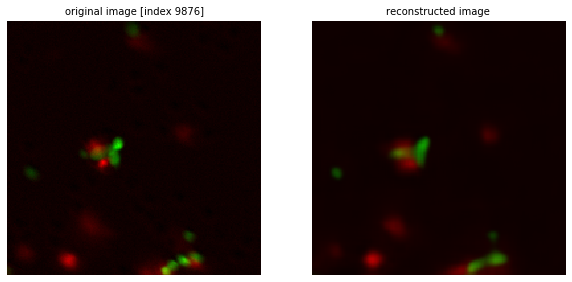

Clustering encoded images
t-sne dimensionality reduction started at 17:42:16
t-sne took 0:06:03.891476 to finish
UMAP dimensionality reduction started at 17:48:20
UMAP took 0:00:47.289042 to finish


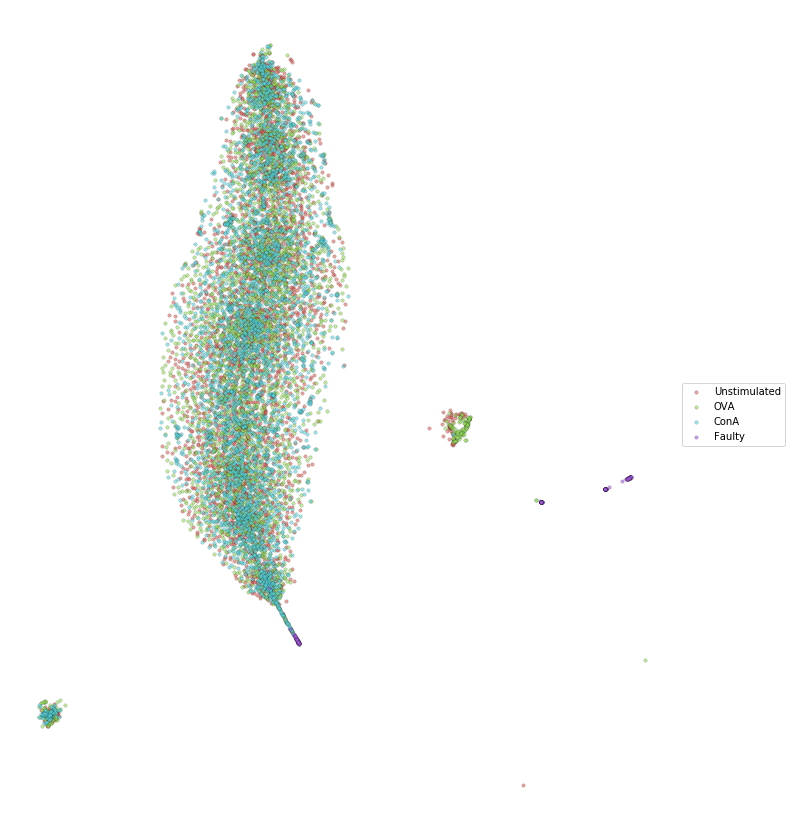

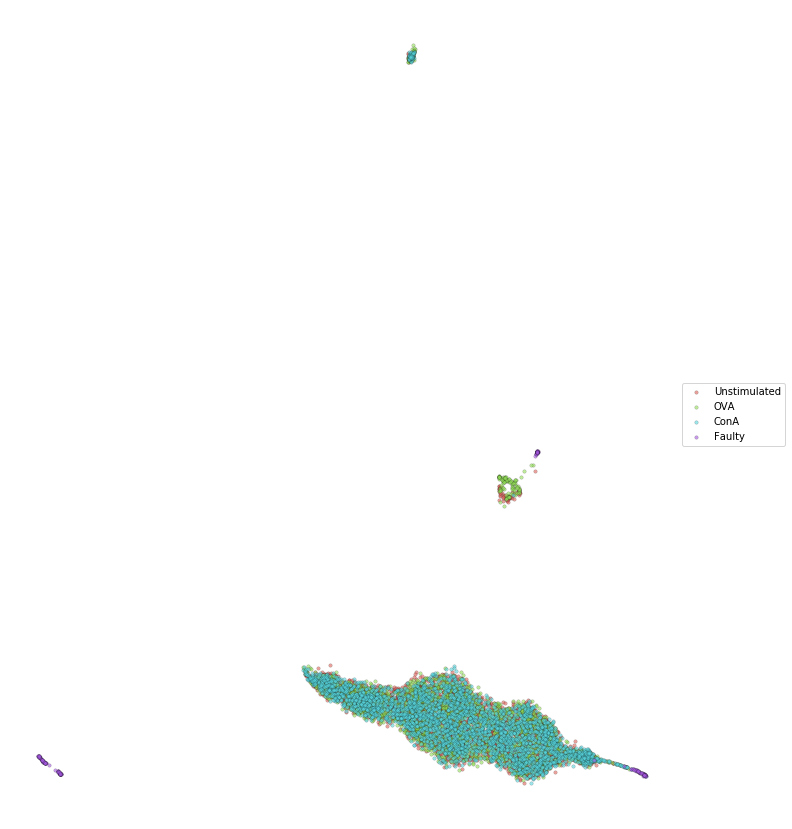

In [27]:
# evaluate
evaluate_autoencoder(decoder, x_combined, tag)

# run clustering
encoded_imgs = encoder.predict(x_combined)

print("Clustering encoded images")
x_tsne, x_umap = run_both(encoded_imgs, random_state=RS)

plot_clusters(x_tsne, y_combined, tag=tag+"_tsne")
plot_clusters(x_umap, y_combined, tag=tag+"_umap")

### Evaluate regression:

In [0]:
# run regression
print("Running regression using encoder model...")

y_pred = regression.predict(x_combined)
evaluate_regression(y_overlaps, y_pred, y_no_faulty)

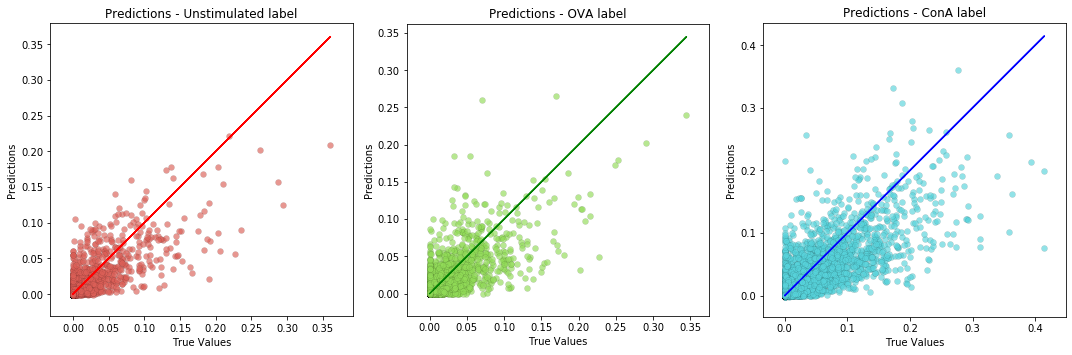

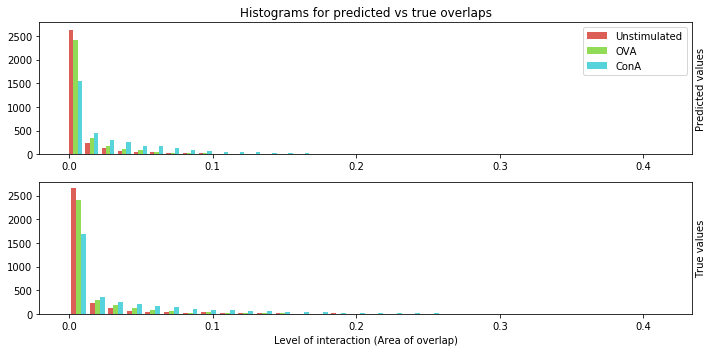

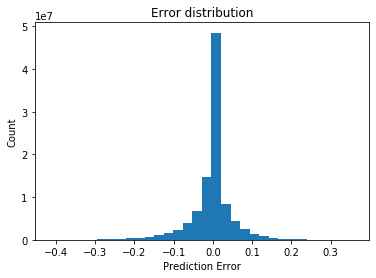

MSE score: 0.0007344160112552345 -- this is the average square difference between true and predicted
RMSE score: 0.027100110426545143 -- difference between T and P in DV unit
R2 score: -16049.5673828125 -- explains variance. closest to 1 is better


In [24]:
evaluate_regression(y_overlaps, y_pred, y_no_faulty, tag=tag)